## Analyze (transfer learning of 3class dataset )

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import panns_inference
from panns_inference import AudioTagging, SoundEventDetection, labels

def print_audio_tagging_result(clipwise_output):
    """Visualization of audio tagging result.

    Args:
      clipwise_output: (classes_num,)
    """
    sorted_indexes = np.argsort(clipwise_output)[::-1]

    # Print audio tagging top probabilities
    number = 10
    if number > len(labels): number = len(labels)
    for k in range(number):
        print('{}: {:.3f}'.format(np.array(labels)[sorted_indexes[k]], 
            clipwise_output[sorted_indexes[k]]))


def plot_sound_event_detection_result(framewise_output):
    """Visualization of sound event detection result. 

    Args:
      framewise_output: (time_steps, classes_num)
    """
    out_fig_path = 'results/sed_result.png'
    os.makedirs(os.path.dirname(out_fig_path), exist_ok=True)

    classwise_output = np.max(framewise_output, axis=0) # (classes_num,)

    idxes = np.argsort(classwise_output)[::-1]
    idxes = idxes[0:5]

    ix_to_lb = {i : label for i, label in enumerate(labels)}
    lines = []
    for idx in idxes:
        line, = plt.plot(framewise_output[:, idx], label=ix_to_lb[idx])
        lines.append(line)

    plt.legend(handles=lines)
    plt.xlabel('Frames')
    plt.ylabel('Probability')
    plt.ylim(0, 1.)
    plt.savefig(out_fig_path)
    print('Save fig to {}'.format(out_fig_path))


In [12]:
if __name__ == '__main__':
    """Example of using panns_inferece for audio tagging and sound evetn detection.
    """
    device = 'cpu' # 'cuda' | 'cpu'
    #audio_path = 'resources/R9_ZSCveAHg_7s.wav'
    audio_path = 'resources/blues.00000.wav'
    
    (audio, _) = librosa.core.load(audio_path, sr=32000, mono=True)
    audio = audio[None, :]  # (batch_size, segment_samples)
    
    checkpoint_path="CNN14_transfer_music_3class.pth"
    #checkpoint_path="10000_iterations3class_notfreeze.pth"
    print('------ Audio tagging ------')
    at = AudioTagging(checkpoint_path=checkpoint_path, device=device)
    (clipwise_output, embedding) = at.inference(audio)
    """clipwise_output: (batch_size, classes_num), embedding: (batch_size, embedding_size)"""

    print_audio_tagging_result(clipwise_output[0])

    #print('------ Sound event detection ------')
    #sed = SoundEventDetection(
    #    checkpoint_path=None, 
    #    device=device, 
    #    interpolate_mode='nearest', # 'nearest'
    #)
    #framewise_output = sed.inference(audio)
    #"""(batch_size, time_steps, classes_num)"""

    #plot_sound_event_detection_result(framewise_output[0])

------ Audio tagging ------
Checkpoint path: CNN14_transfer_music_3class.pth
classes_num= 3
Using CPU.
blues: 0.930
classical: 0.054
country: 0.016


### Inference of train data

In [3]:
import glob
BASE = "../dataset_root2/"
sound_path = BASE + ""

In [4]:
sound_paths = glob.glob(os.path.join(sound_path +'/*/', '*.wav'))
sound_paths.sort()
#sound_paths=sound_paths[:10]
sound_paths

['../dataset_root2/blues/blues.00000.wav',
 '../dataset_root2/blues/blues.00001.wav',
 '../dataset_root2/blues/blues.00002.wav',
 '../dataset_root2/blues/blues.00003.wav',
 '../dataset_root2/blues/blues.00004.wav',
 '../dataset_root2/blues/blues.00005.wav',
 '../dataset_root2/blues/blues.00006.wav',
 '../dataset_root2/blues/blues.00007.wav',
 '../dataset_root2/blues/blues.00008.wav',
 '../dataset_root2/blues/blues.00009.wav',
 '../dataset_root2/blues/blues.00010.wav',
 '../dataset_root2/blues/blues.00011.wav',
 '../dataset_root2/blues/blues.00012.wav',
 '../dataset_root2/blues/blues.00013.wav',
 '../dataset_root2/blues/blues.00014.wav',
 '../dataset_root2/blues/blues.00015.wav',
 '../dataset_root2/blues/blues.00016.wav',
 '../dataset_root2/blues/blues.00017.wav',
 '../dataset_root2/blues/blues.00018.wav',
 '../dataset_root2/blues/blues.00019.wav',
 '../dataset_root2/blues/blues.00020.wav',
 '../dataset_root2/blues/blues.00021.wav',
 '../dataset_root2/blues/blues.00022.wav',
 '../datase

In [13]:
from tqdm.notebook import tqdm
if __name__ == '__main__':

    device = 'cpu' # 'cuda' | 'cpu'
   
    results=[]
    
    checkpoint_path="CNN14_transfer_music_3class.pth"
    at = AudioTagging(checkpoint_path=checkpoint_path, device=device)
    
    for audio_path in tqdm(sound_paths):
        (audio, _) = librosa.core.load(audio_path, sr=32000, mono=True)
        audio = audio[None, :]  # (batch_size, segment_samples)
    
        #print(audio_path)
        category = os.path.split(audio_path)[1].split('.')[0] #ファイル名からラベル抽出        
        #print(category)
        category_index = labels.index(category)
        
        (clipwise_output, embedding) = at.inference(audio)
        """clipwise_output: (batch_size, classes_num), embedding: (batch_size, embedding_size)"""
        
        a = clipwise_output[0].tolist()
        a.append(np.argmax(clipwise_output[0]))
        a.append(category_index)
        results.append(a)
        #print_audio_tagging_result(clipwise_output[0])
        #break

Checkpoint path: CNN14_transfer_music_3class.pth
classes_num= 3
Using CPU.


  0%|          | 0/300 [00:00<?, ?it/s]

In [14]:
new_columns = labels +['pred'] + ['true']
new_columns

['blues', 'classical', 'country', 'pred', 'true']

In [15]:
pred_df = pd.DataFrame(results, columns=new_columns)
pred_df

,blues,classical,country,pred,true
0,0.929672,0.054199,0.016129,0,0
1,0.956490,0.021962,0.021548,0,0
2,0.958251,0.026061,0.015688,0,0
3,0.946062,0.033228,0.020710,0,0
4,0.971504,0.018040,0.010456,0,0
...,...,...,...,...,...
295,0.021107,0.032808,0.946085,2,2
296,0.014560,0.035228,0.950212,2,2
297,0.013015,0.025634,0.961351,2,2
298,0.016423,0.035023,0.948554,2,2


### Confusion_matrix

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import pprint
from sklearn.metrics import f1_score,fbeta_score

def visualize_confusion_matrix(
        y_true,
        pred_label,
        height=.6,
        labels=None):
    """混合行列をプロット 
    (https://www.guruguru.science/competitions/11/discussions/2fb11851-67d0-4e96-a4b1-5629b944f363/)"""
    
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                           ) #normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 4, size * 3))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    plt.show()
    #return fig

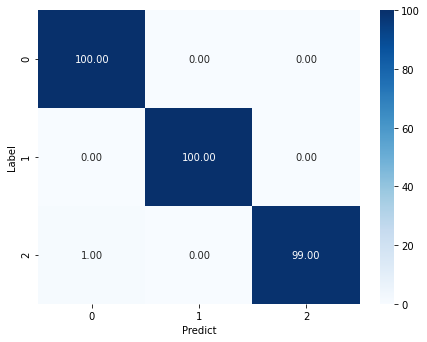

In [22]:
preds = pred_df["pred"].values
true_labels = pred_df["true"].values

visualize_confusion_matrix(
        true_labels ,
        preds,
        height=.6,
        labels=None)

### Classification_report

In [18]:
#f1 = f1_score(true_labels, preds, average='micro')
#fbeta = fbeta_score(true_labels, preds, beta=7.0, average='micro')
#print(f'f1_score = {f1}')
#print(f'fbeta(7) = {fbeta}')
#print('---'*20)
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      0.99      0.99       100

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



### ROC curve (Binary)

In [26]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [29]:
metrics.roc_auc_score(true_labels, preds, labels = labels, multi_class = 'ovo', average = 'macro')

AxisError: axis 1 is out of bounds for array of dimension 1

In [30]:
from sklearn import metrics
import matplotlib.pyplot as plt

# FPR, TPR, thresh
fpr, tpr, thresholds = metrics.roc_curve(true_labels, preds)

# AUC
auc = metrics.auc(fpr, tpr)
print(f'auc = {auc}')
# ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

ValueError: multiclass format is not supported

### PR curve (Binary)

In [31]:
#https://qiita.com/g-k/items/b47b9b0ee2015a3b0b94#pr%E6%9B%B2%E7%B7%9A
precision, recall, thresholds = metrics.precision_recall_curve(true_labels, preds)

#AUC
auc = metrics.auc(recall, precision)
print(auc)

# PR curve
plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
plt.legend()
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

ValueError: multiclass format is not supported

## Multiclass Analysis

In [ ]:
# https://github.com/vinyluis/Articles/tree/main

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

## Functions
Slightly modified from the binary classifier case

In [82]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [83]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [84]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

## Data

In [85]:
classes = labels
classes

['blues', 'classical', 'country']

In [101]:
y_proba = np.array(pred_df[['blues','classical','country']])
y_proba

array([[0.92967153, 0.05419948, 0.01612901],
       [0.95648968, 0.02196226, 0.02154819],
       [0.95825064, 0.02606107, 0.01568826],
       [0.94606197, 0.03322823, 0.02070982],
       [0.97150403, 0.0180396 , 0.01045636],
       [0.96794111, 0.02715981, 0.004899  ],
       [0.96722609, 0.02202577, 0.01074813],
       [0.97632694, 0.01600395, 0.00766907],
       [0.93810564, 0.03831443, 0.02357984],
       [0.96904647, 0.02453073, 0.00642279],
       [0.90986365, 0.04879363, 0.04134273],
       [0.9757691 , 0.01628548, 0.00794545],
       [0.946666  , 0.04494444, 0.00838945],
       [0.93695533, 0.04538099, 0.01766368],
       [0.94127339, 0.050313  , 0.00841365],
       [0.93504775, 0.05698105, 0.00797123],
       [0.94986427, 0.04194844, 0.00818742],
       [0.96769923, 0.02384132, 0.00845936],
       [0.9484995 , 0.0348741 , 0.01662642],
       [0.96972382, 0.02598914, 0.00428706],
       [0.9675197 , 0.02752438, 0.00495594],
       [0.96600425, 0.0213048 , 0.01269095],
       [0.

In [66]:
y_test= [labels[x] for x in pred_df['true']]
y_test

['blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',
 'blues',


## ROC Curve - One vs Rest (OvR)
Compares each class with the rest of the classes

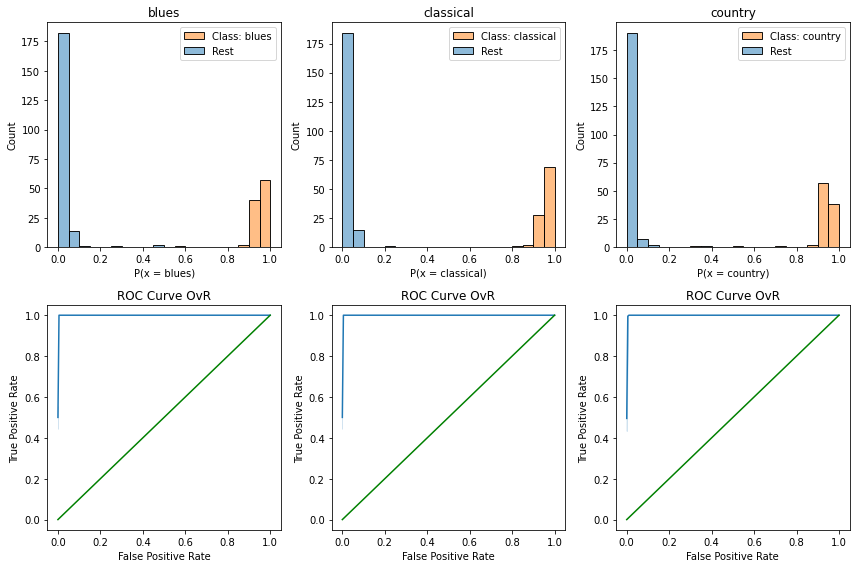

In [106]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    #print("c =",c)
    
    # Prepares an auxiliar dataframe to help with the plots
    #df_aux = X_test.copy()
    df_aux = pred_df.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

In [104]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

blues ROC AUC OvR: 1.0000
classical ROC AUC OvR: 1.0000
country ROC AUC OvR: 1.0000
average ROC AUC OvR: 1.0000


In [105]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(y_test, y_proba, labels = classes, multi_class = 'ovr', average = 'macro')

0.9999833333333333

## ROC Curve - One vs One (OvO)
Compares each possible combination of the classes, two at a time

In [107]:
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])
classes_combinations

[['blues', 'classical'],
 ['classical', 'blues'],
 ['blues', 'country'],
 ['country', 'blues'],
 ['classical', 'country'],
 ['country', 'classical']]

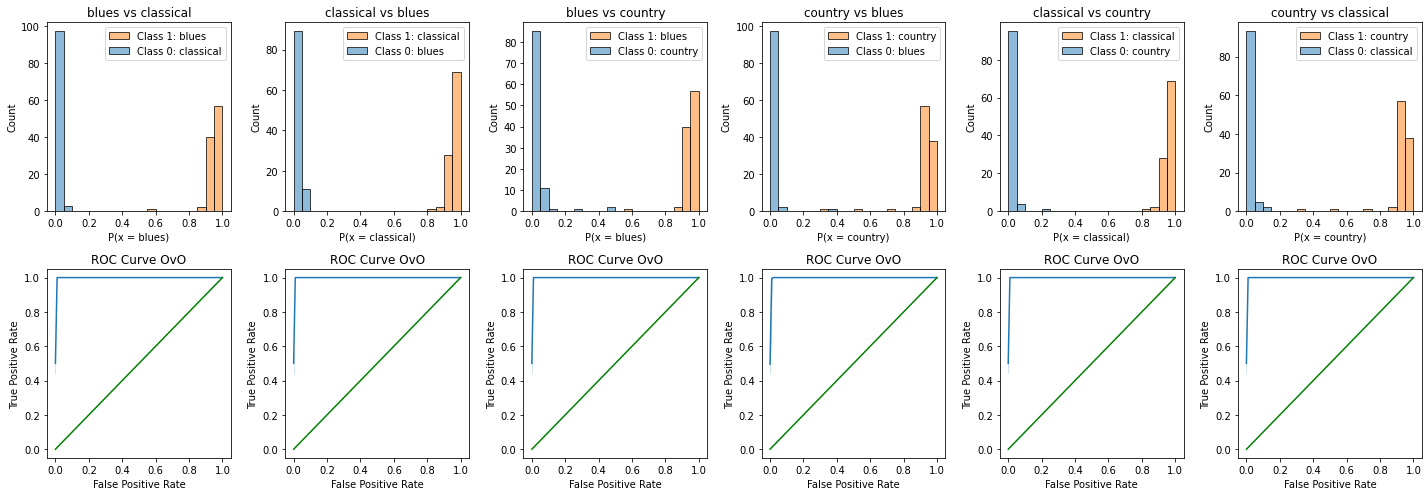

In [110]:
# Plots the Probability Distributions and the ROC Curves One vs ONe
plt.figure(figsize = (20, 7))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}

for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = c1 + " vs " +c2
    
    # Prepares an auxiliar dataframe to help with the plots
    #df_aux = X_test.copy()
    df_aux = pred_df.copy()
    df_aux['class'] = y_test
    df_aux['prob'] = y_proba[:, c1_index]

    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 6, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 6, i+7)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

In [111]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")

blues vs classical ROC AUC OvO: 1.0000
classical vs blues ROC AUC OvO: 1.0000
blues vs country ROC AUC OvO: 1.0000
country vs blues ROC AUC OvO: 0.9999
classical vs country ROC AUC OvO: 1.0000
country vs classical ROC AUC OvO: 1.0000
average ROC AUC OvO: 1.0000


In [109]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(y_test, y_proba, labels = classes, multi_class = 'ovo', average = 'macro')

0.9999833333333333